In [94]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

In [95]:
with open("songs.txt", "r") as f:
    songs = list(set(f.read().split('\n\n')))

In [96]:
len(songs)

616

In [97]:
songs[:5]

["Well the Ukraine girls really knock me out,\nThey leave the west behind.\nAnd Moscow girls make me sing and shout,\nThat Georgia's always on my mi-mi-mi-mi-mind.",
 "My baby says she's trav'ling on the one after 909.\nI said move over honey I'm travelling on that line.\nI said move over once, move over twice,\nCome on baby don't be cold as ice.\nI said I'm trav'ling on the one after 909.",
 'Back in school again,\nMaxwell plays the fool again,\nTeacher gets annoyed.\nWishing to avoid\nAn unpleasant sce-e-e-ene.\nShe tells Max to stay\nWhen the class has gone away,\nSo, he waits behind.\nWriting fifty times,\nI must not be so-o-o-o.\nBut, when she turns her back on the boy,\nHe creeps up from behind.',
 "Oh, I get by with a little help from my friends,\nMm, I get high with a little help from my friends,\nMm, I'm gonna try with a little help from my friends.",
 "I've got my bag,\nRun to the station.\nRailman says\nYou've got the wrong location.\nI've got my bag,\nRun right home.\nThen 

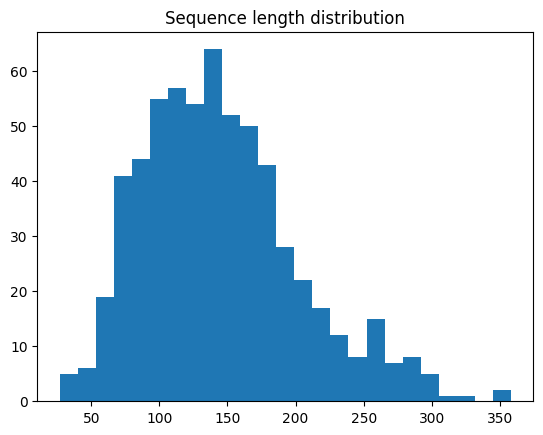

In [98]:
plt.title('Sequence length distribution')
plt.hist(list(map(len, songs)),bins=25);

In [99]:
songs = [s for s in songs if len(s) < 300 and len(s) > 50]

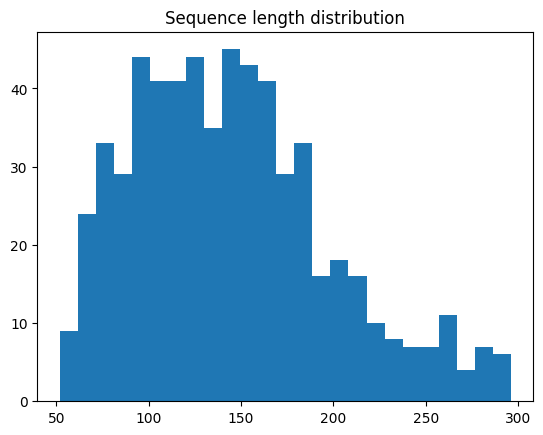

In [100]:
plt.title('Sequence length distribution')
plt.hist(list(map(len, songs)),bins=25);

In [101]:
class MyTokenizer():
    def __init__(self, start_token="<sos>", end_token="<eos>", pad_token="_", punctuation: list[chr]=None, ignore_symbols: list[chr]=None):
        self.start_token = start_token
        self.end_token = end_token
        self.pad_token = pad_token
        self.tokens = set()
        self.max_length = 0
        self.tokens_ids = {}
        self.punctuation = [',', '!', '?', ':', '.', ';'] if not punctuation else punctuation
        self.ignore_symbols = ignore_symbols

    def __translate_table(self, symbols):
        dict = {}
        for sym in symbols:
            dict[ord(sym)] = ''
        return dict

    def make_tokens(self, text: list[str]):
        self.tokens = set()
        if self.punctuation:
            text = [s.translate(self.__translate_table(self.punctuation)) for s in text]
            self.tokens.update(self.punctuation)
        if self.ignore_symbols:
            text = [s.translate(self.__translate_table(self.ignore_symbols)) for s in text]
        for str in text:
            self.tokens.update(str.split())
        self.tokens.update([' ', '\n'])
        
        self.tokens.add(self.start_token)
        self.tokens.add(self.end_token)
        self.tokens.add(self.pad_token)
        self.tokens = list(self.tokens)
        self.max_length = len(self.tokens)
        self.tokens_ids = {token: idx for idx, token in enumerate(self.tokens)}
        return self.tokens
    
    def to_tokens(self, text: list[str]):
        matrix = []
        for s in text:
            stext = s
            s = s.replace(' ', str(self.tokens_ids[' ']) + ' ')
            for token in sorted(self.tokens, key=lambda x: len(x), reverse=True):
                if token == ' ':
                    continue
                s = s.replace(token, str(self.tokens_ids[token]) + ' ')
            try:
                row = [int(id) for id in s.split()]
            except:
                raise ValueError(stext)
            row = [self.tokens_ids[self.start_token]] + row + [self.tokens_ids[self.end_token]]
            matrix.append(row)

        max_length = max(map(len, matrix))
        for row in matrix:
            if len(row) < max_length:
                for _ in range(max_length - len(row)):
                    row.append(self.tokens_ids[self.pad_token])
        
        return torch.tensor(matrix)
    
    def to_text(self, token_matrix: torch.Tensor):
        result_text = ""
        for row in token_matrix:
            for id in row[1:-1]:
                result_text += self.tokens[id]
        
        return result_text

In [102]:
start_token = "<sos>"
end_token = "<eos>"
pad_token = "_"

In [103]:
tokenizer = MyTokenizer(start_token, end_token, pad_token)
tokens = tokenizer.make_tokens(songs)
num_tokens = len(tokens)
num_tokens

2130

In [104]:
assert len(tokenizer.tokens) == len(tokenizer.tokens_ids), "dictionaries must have same size"

for i in range(num_tokens):
    assert tokenizer.tokens_ids[tokenizer.tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [105]:
tokenizer.to_tokens(songs[:10])

tensor([[1054, 1301,  936,  840,  936,  758,  936,  326,  936,  350,  936,  738,
          936,  574,  936, 1940,  163, 1650, 2089,  936, 1248,  936,  840,  936,
         2072,  936, 1785, 1351, 1650, 1088,  936,  572,  936,  326,  936,  652,
          936,  574,  936,  828,  936,  682,  936,  809,  163, 1650, 1833,  936,
          773,  936,  912,  936,  254,  936, 1420,  936, 1092, 1351, 1923,  972,
          972,  972,  972,  972,  972,  972,  972,  972,  972,  972,  972,  972,
          972,  972,  972,  972,  972,  972,  972,  972,  972,  972,  972,  972,
          972,  972,  972,  972,  972,  972,  972,  972,  972,  972,  972,  972,
          972],
        [1054, 1875,  936,  864,  936, 1655,  936, 2109,  936,  231,  936,  254,
          936,  840,  936, 1061,  936,  313,  936,  325, 1351, 1650, 1789,  936,
         1600,  936, 1862,  936,  545,  936,  507,  936, 1533,  936,  904,  936,
          254,  936, 1473,  936, 2068, 1351, 1650, 1789,  936, 1600,  936, 1862,
          93

In [106]:
songs[6]

"Hold me, love me, hold me, love me,\nAin't got nothing' but love girl,\nEight days a week,\nEight days a week,\nEight days a week."

In [107]:
# tokens[1475]

In [108]:
matrix = tokenizer.to_tokens(songs)

In [109]:
torch._is_any_true(matrix > len(tokens)-1)

tensor(False)

In [110]:
print(tokenizer.to_text(matrix))

Well the Ukraine girls really knock me out,
They leave the west behind.
And Moscow girls make me sing and shout,
That Georgia's always on my mi-mi-mi-mi-mind.<eos>____________________________________________________________________________My baby says she's trav'ling on the one after 909.
I said move over honey I'm travelling on that line.
I said move over once, move over twice,
Come on baby don't be cold as ice.
I said I'm trav'ling on the one after 909.<eos>______________________________________Oh, I get by with a little help from my friends,
Mm, I get high with a little help from my friends,
Mm, I'm gonna try with a little help from my friends.<eos>______________________________________________________________I've got my bag,
Run to the station.
Railman says
You've got the wrong location.
I've got my bag,
Run right home.
Then I find
I've got the number wrong.<eos>____________________________________________________________________His rival it seems had broken his dreams by stealing 

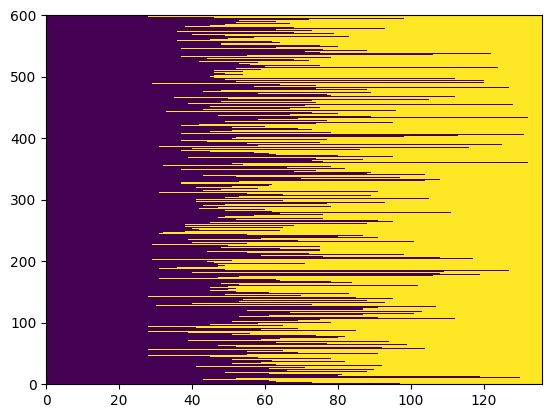

In [111]:
plt.pcolormesh(matrix == tokenizer.tokens_ids[pad_token])

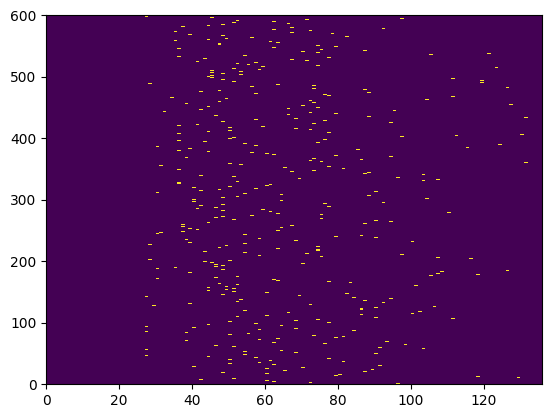

In [112]:
plt.pcolormesh(matrix == tokenizer.tokens_ids[end_token])

![picture](rnn.png)

In [113]:
class MyRnnCell(nn.Module):
    def __init__(self, num_tokens, embeds_dim, hid_num_units):
        super().__init__()
        self.num_hidden = hid_num_units
        self.embedding = nn.Embedding(num_tokens, embeds_dim)
        self.update = nn.Linear(embeds_dim + self.num_hidden, self.num_hidden)
        self.activation = nn.Tanh()
        self.to_logits = nn.Linear(self.num_hidden, num_tokens)

    def forward(self, input_seq, hidden):
        inp_embed = self.embedding(input_seq)
        full_embed = torch.cat([hidden, inp_embed], dim=-1)
        new_hidden = self.activation(self.update(full_embed))
        logits = self.to_logits(new_hidden)

        return logits, new_hidden

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_hidden, requires_grad=True)


In [114]:
class MyRnnNetwork(nn.Module):
    def __init__(self, num_tokens, embeds_dim, hid_num_units, depth, tokenizer:MyTokenizer):
        super().__init__()
        self.depth = depth
        self.cells = torch.nn.ModuleList([MyRnnCell(num_tokens, embeds_dim, hid_num_units) for _ in range(depth)])
        self.cat_hiddens = nn.Linear(hid_num_units * 2, hid_num_units)
        self.device = torch.device('cpu')
        self.tokenizer = tokenizer

    def to_device(self, device: torch.device):
        self.device = device
        self.to(device)

    def train_loop(self, batch: torch.tensor):
        batch_size = batch.shape[0]
        hidden_layers = [self.cells[0].initial_state(batch_size).to(self.device) for _ in range(self.depth)]
        logits = []

        for x in batch[:,:-1].T:
            pred_logits, hidden_layers[0] = self.cells[0].forward(x, hidden_layers[0])
            for i in range(1, self.depth):
                cat_hidden = self.cat_hiddens(torch.cat([hidden_layers[i-1], hidden_layers[i]], dim=1))
                pred_logits, hidden_layers[i] = self.cells[i].forward(x, cat_hidden)

            logits.append(pred_logits)

        return torch.stack(logits, dim=1)
    
    def forward(self, num_generations=1, temerature=0.8, seed=''):
        with torch.no_grad():
            verses = []
            hidden_layers = [self.cells[0].initial_state(batch_size=1).to(self.device) for _ in range(self.depth)]#.to(device)
            for _ in range(num_generations):
                sequence = self.tokenizer.to_tokens([seed])[:,:-1].to(self.device)

                # for token in seed_tokens[0,1:-1].T:
                #     _, hidden = rnn_cell.forward(token, hidden)

                while sequence[0,-1] != self.tokenizer.tokens_ids[self.tokenizer.end_token]:
                    logits, hidden_layers[0] = self.cells[0].forward(sequence[0,-1:], hidden_layers[0])
                    for i in range(1, self.depth):
                        cat_hidden = self.cat_hiddens(torch.cat([hidden_layers[i-1], hidden_layers[i]], dim=1))
                        logits, hidden_layers[i] = self.cells[i].forward(sequence[0,-1:], cat_hidden)
                    soft = nn.functional.softmax(logits.cpu() / temerature, dim=1).data.numpy()[0]
                    cur_token = self.tokenizer.tokens_ids[np.random.choice(tokens, p=soft)]
                    sequence = torch.cat((sequence, torch.tensor([[cur_token]], device=self.device)), dim=-1)

                verses.append(self.tokenizer.to_text(sequence))

        return verses

In [115]:
# def rnn_loop(rnn_cell: MyRnnCell, batch: np.array, device):
#     batch_size = batch.shape[0]
#     hidden_layer = rnn_cell.initial_state(batch_size).to(device)
#     logits = []

#     for x in batch[:,:-1].T:
#         pred_logits, hidden_layer = rnn_cell.forward(x, hidden_layer)
#         logits.append(pred_logits)

#     return torch.stack(logits, dim=1)

In [116]:
from IPython.display import clear_output

In [117]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [118]:
def training_loop(rnn_network: MyRnnNetwork, tokenizer: MyTokenizer, train_dataloader, optimizer, loss_fn, device):
    losses = []
    for i in range(1000):
        batch = next(iter(train_dataloader))
        batch = tokenizer.to_tokens(batch).to(device)

        optimizer.zero_grad()
        # logits = rnn_loop(rnn_cell, batch, device)
        logits = rnn_network.train_loop(batch)
        loss = loss_fn(logits.permute(0, 2, 1), batch[:,1:])
        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            losses.append(loss.item())
    return losses
    # assert np.mean(losses[:10]) > np.mean(losses[-10:]), f"RNN didn't converge."

In [130]:
def train(rnn_network: MyRnnNetwork, tokenizer: MyTokenizer, train_dataloader, optimizer, loss_fn, device):
    rnn_network.train()
    losses = []
    for epoch in range(70):
        losses += training_loop(rnn_network, tokenizer, train_dataloader, optimizer, loss_fn, device)
        clear_output(True)
        print(f"Epoch {epoch+1}")
        plt.legend("CrossEntropyLoss")
        plt.plot(losses)
        plt.show()
    rnn_network.eval()
    return losses[-1]

In [131]:
rnn_network = MyRnnNetwork(len(tokens), 35, 100, 2, tokenizer)
rnn_network.to_device(device)
optimizer = torch.optim.Adam(rnn_network.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.tokens_ids[tokenizer.pad_token])

songs_dataloader = torch.utils.data.DataLoader(songs, batch_size=16, shuffle=True)

In [132]:
rnn_network

MyRnnNetwork(
  (cells): ModuleList(
    (0-1): 2 x MyRnnCell(
      (embedding): Embedding(2130, 35)
      (update): Linear(in_features=135, out_features=100, bias=True)
      (activation): Tanh()
      (to_logits): Linear(in_features=100, out_features=2130, bias=True)
    )
  )
  (cat_hiddens): Linear(in_features=200, out_features=100, bias=True)
)

In [133]:
rnn_network.forward()

["SomeoneAlltragicegg-menYesterdayunpackdoesn'tluckyreplyApologizeI'llsawmatterliedSongnervespeakknownMichellesmilingShowcleaneye-ballThat'sstaringThey'resunshineHeyBeneathwellcouldBrightraiseevolutionjockeyThere'syou'veWithEv'ryoneCandiesIsn'twipingceilingbrightrentPostmantonightputtingWorldcongobrownhe'sJustalonerunningpleasthatclubgrowTheymetarthritichugsuburbanstandingspinningstandWouldcloudchildrenWigwamsucceedthinkyourslotmeanyeahgoopaslist'ningDacertainagreelist'ningStepstaysomebodyMichellegumbootengagedspendpouringbringsuswelltow'lnineteenMojothat'ssleptKeepspneumoniaproudpouringholesearlytrackswonderLikeBig'waysighmiddleLAsmilingsittingBulldogbooktroublebirdsdoesn'tSillyLadyyou'dstarerockingspoilgravecarryspeedAlthoughsaferestlessSavingimaginedgoingopenedlaughgraveThiswannahurryWorldpolythenejealouslegendtroubleAskedendlessObladiknickerSpendingApologizehowecaughtLikemoneystoresheartboybreakfastSpeakingmakingwatersaysanybodyearthlorryBirthdayjawningLookalreadypolicescrimpenough

Epoch 70


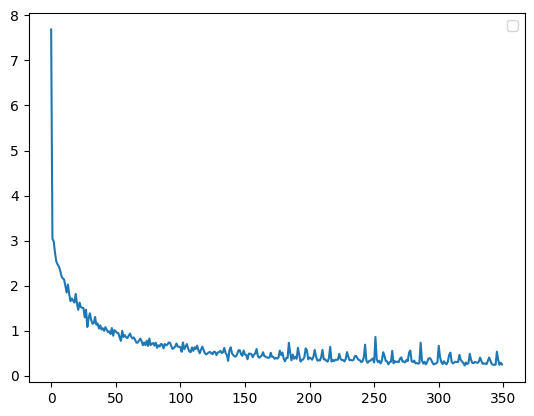

Result Loss: 0.25327005982398987


In [134]:
result_loss = train(rnn_network, tokenizer, songs_dataloader, optimizer, loss_fn, device)
print(f"Result Loss: {result_loss}")

In [613]:
# def gen_sample(rnn_cell: MyRnnCell, tokenizer: MyTokenizer, length=1, temerature=0.8, seed='', device=device):
#     with torch.no_grad():
#         verses = []
#         hidden = rnn_cell.initial_state(batch_size=1).to(device)
#         for _ in range(length):
#             sequence = tokenizer.to_tokens([seed])[:,:-1].to(device)

#             # for token in seed_tokens[0,1:-1].T:
#             #     _, hidden = rnn_cell.forward(token, hidden)

#             while sequence[0,-1] != tokenizer.tokens_ids[tokenizer.end_token]:
#                 logits, hidden = rnn_cell.forward(sequence[0,-1:], hidden)
#                 soft = nn.functional.softmax(logits.cpu() / temerature, dim=1).data.numpy()[0] 
#                 cur_token = tokenizer.tokens_ids[np.random.choice(tokens, p=soft)]
#                 sequence = torch.cat((sequence, torch.tensor([[cur_token]], device=device)), dim=-1)

#             verses.append(tokenizer.to_text(sequence))
#     return verses

In [135]:
gen_song = rnn_network.forward(num_generations=5)
print(*gen_song, sep='\n\n')

I don't want to share,
Each one believing that it's travelling she done.
Nothing is real, and nothing to get hung about
Strawberry fields forever.

Help it
With don't know I want to help of alright.

Take no have not satisfied I could do
Just the wind never are you that we things,
She once had so as from the turnstile,
Stay girl love that you break you.
My love not the jewellers stores,
Buys a twenty carat golden ring.
Takes it back to Molly waiting at the door
And so shy to be that and he comes to be
There is really set nobody free before,
This boy, no into submarines.

Take a good are free has think she's but to see,
Some are sun.

Take asked me harm,
My independence just the same.


In [136]:
# gen_song = gen_sample(rnn_cell, tokenizer, length=5)
# print(*gen_song, sep='\n\n')

In [137]:
torch.save(rnn_network.state_dict(), 'song_generation_network2.pt')

In [32]:
torch.cuda.empty_cache()
del rnn_network